In [1]:
from datetime import date, timedelta
import datetime as dt
from dateutil.parser import parse
from typing import Sequence
from pathlib import Path
import sh 
import gc

from PIL import Image


import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import figure
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm         as cm
import matplotlib.colors     as mcolors
import matplotlib.patches    as mpatches
import matplotlib.transforms as mtransforms
import matplotlib.dates      as mdates

import matplotlib

from netCDF4 import Dataset
import geomagdata as gi
import pyproj

import pylab
from pylab import *
import pywt 

import scipy.io        as scio
import scipy.constants as const
from   scipy.fftpack   import fft
from   scipy.stats     import chi2
from scipy.signal import butter, filtfilt, savgol_filter


In [2]:
def FFT(Fs, data):
    L = len(data)

    N = np.power(2, np.ceil(np.log2(L)))
    N = int(N)

    FFT_y = np.abs(fft(data,N))/L*2
    Fre   = np.arange(int(N/2))*Fs/N
    FFT_y = FFT_y[range(int(N/2))]
    
    return Fre, FFT_y

# 计算lags阶以内的自相关系数，返回lags个值，将序列均值、标准差视为不变
def autocorrelation(x,lags):
    n = len(x)
    x = np.array(x)
    variance = x.var()
    x = x-x.mean()
    result = np.correlate(x, x, mode = 'full')[-n+1:-n+lags+1]/\
    (variance*(np.arange(n-1,n-1-lags,-1)))
    return result




In [3]:
def lla2ecef(lon, lat, alt):
    lla = {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'}
    ecef = {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'}
    transformer = pyproj.Transformer.from_crs(lla,ecef,always_xy = True)
    return transformer.transform(lon,lat,alt,radians = False)

def ecef2lla(x, y, z):
    lla = {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'}
    ecef = {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'}
    transformer = pyproj.Transformer.from_crs(ecef,lla,always_xy = True)
    return transformer.transform(x,y,z,radians = False)

In [4]:
def distance_between(epicenter_ll, IPP_ll, radians = False):
    
    """ units: km """    
    
#     radium = 6378+400
    # Height =  400*1000
    Height = 0
    
    lambda_a, phi_a = epicenter_ll
    lambda_b, phi_b = IPP_ll
    
    x1, y1, z1 = lla2ecef(lambda_a, phi_a, Height)
    x2, y2, z2 = lla2ecef(lambda_b, phi_b, Height)
    
    vector1 = np.array([x1, y1, z1])
    radium1 = np.sqrt(np.dot(vector1, vector1))/1000
    
    vector2 = np.array([x2, y2, z2])
    radium2 = np.sqrt(np.dot(vector2, vector2))/1000
    
    radium = (radium1 + radium2)/2
#     print('radium:', radium)
    
    if not radians:
        lambda_a = np.radians(lambda_a)
        lambda_b = np.radians(lambda_b)
        phi_a    = np.radians(phi_a)
        phi_b    = np.radians(phi_b)
    
    cosine = np.cos(phi_a)*np.cos(phi_b)*np.cos(lambda_a-lambda_b) + \
             np.sin(phi_a)*np.sin(phi_b)
    
    delta  = np.arccos(cosine)
    
    distance = radium * delta
    
    return distance

In [5]:
def data_trend(dat, level = 2):
    winsize = len(dat)
    t   = np.arange(1,winsize+1,1)
    idx = np.isfinite(dat)
    p   = np.polyfit(t[idx], dat[idx], level)
#             p            = np.polyfit(t, dat, 1)
#     trend = np.polyval(p, t)
    return p


In [6]:
class Signal(object):
    def __init__(self, signals, sample_rate):
        self.name = 'signals'
        # self.signals = signals
        self.sample_rate = sample_rate
        
        nan_idx      = np.isnan(signals)
        # 找到数组中非 NaN 值的位置
        not_nan_idx = np.logical_not(nan_idx)
        # 使用插值函数 interp() 对 NaN 值进行插值
        signals[nan_idx] = np.interp(nan_idx.nonzero()[0], not_nan_idx.nonzero()[0], signals[not_nan_idx])
        self.signals = signals

    def butter_bandpass(self, cut_off_frequency_list, order=5):
        ''' 带通滤波器，需要两个截止频率，以 list 形式输入 '''
        self.nyq = 0.5 * self.sample_rate
        normal_cut_off = np.array(cut_off_frequency_list) / self.nyq
        b, a = butter(order, normal_cut_off,
                      btype="bandpass", analog=False)
        return b, a

    def butter_bandpass_filtfilt(self, cut_off_frequency_list, order=5):
        ''' 带通滤波器的执行，消除延迟 '''
        b, a = self.butter_bandpass(cut_off_frequency_list, order=order)
        y = filtfilt(b, a, self.signals)
        return y
    
    def savgol_dtrend_filter(self, winsize, order = 3):
        trend  = savgol_filter(self.signals, winsize ,order)
        dtrend = self.signals - trend
        return dtrend
    

In [7]:
def format_func(x, 
                pos=None
               ):
    x = mdates.num2date(x)
    
    if x.hour == 0 and x.minute == 0:
        fmt = '%b %d'
#     elif 
#         fmt = '%H\n%m/%d'
    else:
        fmt = '%H'
        
    label = x.strftime(fmt)
    
    return label


def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距,width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax

In [8]:
def plot_time_distance_variation(ax, time, distances, data, vmin = -1.6, vmax = 1.6, cmap = 'bwr'):  
    for i, distance in enumerate(distances):
        D = [distance]*len(time) 
        im = ax.scatter(time, D, 
                        c = data[i],
                        vmin = vmin,
                        vmax = vmax,
                        s = 5,
                        marker = ',',
                        linewidths = 0,
                        cmap = cmap
                       )
    return im

In [9]:
def plot_time_distance_vibration(ax, time, distances, data, vmin = -1.6, vmax = 1.6, cmap = 'bwr'):  
    for i, distance in enumerate(distances):
        # D = [distance]*len(time) 
        sc = ax.scatter(time, distance+data[i], 
                     c = distance+data[i],
                        vmin = distance+vmin,
                        vmax = distance+vmax,
                        s = 0.5,
                        marker = ',',
                        linewidths = 0,
                        cmap = cmap
                       )
#         ax.axhline( distance,
#             linestyle = '--',
#             color = 'grey',
#             alpha = 0.25,
#                    linewidth = 0.02
# #             zorder = -100
#            )
    return sc

In [10]:
def plot_arrival_time_line(ax, tstart, tend, pstart, pend, notes = 'notation', portion = 0.25):
    ax.plot([tstart, tend], [pstart, pend], color = 'grey', alpha = 0.35)
    ax.annotate(notes, 
                [tstart+(tend-tstart)*portion, pstart+(pend-pstart)*portion], 
                xytext=[10,0], 
                textcoords='offset points'
                )

In [11]:
1/(50*60)

0.0003333333333333333

In [12]:
obs = {}
sample_rate= 1

# lowlimit   = 1/3600
# highlimit  = 0.49
# filtering = '1hr-2s Butterworth filter'             # order: 5
# vmin = -1.6      # scatter plot paarmeter
# vmax = 1.6

# lowlimit   = 1.0/(50*60)
# highlimit  = 1.0/(30*60)
# filtering = '50min-30min Butterworth filter'        # order: 3
# vmin = -1.1
# vmax = 1.1

# lowlimit   = 1.0/(20*60)
# highlimit  = 1.0/(12*60)
# filtering = '20min-12min Butterworth filter'        # order: 3
# vmin = -0.8
# vmax = 0.8

sample_rate = 1
# cut_off_frequency_list = [lowlimit, highlimit]

# SGwinsize = 60*60+1                        # should be odd 
# filtering = '60min Savitzky-Golay detrended'            # order: 5
# vmin = -5
# vmax = -vmin

# SGwinsize = 50*60+1                        # should be odd 
# filtering = '50min Savitzky-Golay detrended'            # order: 5
# vmin = -1.2    # 1.5
# vmax = -vmin
# zoomer = 50

# SGwinsize = 40*60+1                        # should be odd 
# filtering = '40min Savitzky-Golay detrended'            # order: 5
# vmin = -2
# vmax = -vmin

SGwinsize = 30*60+1                        # should be odd 
filtering = '30min Savitzky-Golay detrended'            # order: 5
vmin = -1.6
vmax = -vmin
zoomer = 15

event_date       = datetime.date(2022,1,15).strftime('%Y_%m_%d')
epicenter        = 'Tonga'
epictime         = np.datetime64('2022-01-15T04:20','m')
src_dir  = Path(f'/run/media/echoo/TOSHIBA EXT/GNSS/{event_date}_{epicenter}')

save_dir  = Path(f'/home/echoo/echoo/mycode/PLOT/{event_date}_{epicenter}')
epicenter_ll    = [-175.8, -20.5]


# save_dir
if not Path.is_dir(save_dir):
    sh.mkdir(save_dir)
# 
#     C01 - 地球静止轨道140.0°E，高度35807×35782公里，倾角1.6°
#     C02 - 地球静止轨道84.07°E，高度35803×35783公里，倾角1.7°
#     C03 - 地球静止轨道110.45°E，高度35854.3×35885.9公里，倾角1.7°
#     C04 - 地球静止轨道159.98°E，高度35815×35772公里，倾角0.6°
#     C05 - 地球静止轨道58.71°E，高度35801×35786公里，倾角1.4°

svs = [ 'C01', 'C03', 'C02', 'C05']

observers = set()
observer_svs = {}

start = dt.datetime(2022, 1, 15)
end   = dt.datetime(2022, 1, 17)

is_first_day = True
for date in pd.date_range(start+timedelta(days=1), 
                          end-timedelta(days=1), 
                          freq="D"
                         ):
    obs['year']      = date.strftime('%y')
    obs['doy']       = date.strftime('%j')
    obs['samp_rate'] = '01s'

    # src_dir  = Path(f"/run/media/echoo/TOSHIBA EXT")

    TEC_dir  = src_dir/obs['doy']/'TEC'
    TEC_file = f"TEC_{obs['doy']}_{obs['samp_rate']}_{obs['year']}.nc"
    TEC_path = TEC_dir/TEC_file
    
    nc = xr.open_dataset(TEC_path)
    if is_first_day:
        observers = set(nc.observer.values)
    else:
        observers = observers.intersection(set(nc.observer.values) )
        
    for observer in observers:
        if is_first_day:
            observer_svs[observer] = svs.copy()
        for sv in svs:
            sTEC   = nc.sTEC_smth.sel(observer = observer, sv = sv).dropna(dim = 'time') 
            zenith = nc.zenith.sel(observer = observer, sv = sv)
            
            if len(sTEC) < 40000:
                observer_svs[observer].remove(sv)
            try:
                elevation  = 90 - np.degrees(zenith.values)
                if elevation < 32:
                    observer_svs[observer].remove(sv)
            except:
                pass
lons = nc.sel(sv = 'C03').lon.dropna(dim = 'observer').values
lons = sorted(lons, reverse = True)


del nc

data = xr.Dataset()
for obs_count, observer in enumerate(observers):
    
    print(len(observers), obs_count, observer)
    
    sv_count = len(observer_svs[observer])
    for count, sv in enumerate(observer_svs[observer]):
        is_first_day = True
        for date in pd.date_range(start+timedelta(days=1), 
                                  end-timedelta(days=1), 
                                  freq="D"
                                 ):
            obs['year']      = date.strftime('%y')
            obs['doy']       = date.strftime('%j')
            obs['samp_rate'] = '01s'

            # src_dir  = Path(f"/run/media/echoo/TOSHIBA EXT")

            TEC_dir  = src_dir/obs['doy']/'TEC'
            TEC_file = f"TEC_{obs['doy']}_{obs['samp_rate']}_{obs['year']}.nc"
            TEC_path = TEC_dir/TEC_file
            nc = xr.open_dataset(TEC_path)
                
            sTEC   = nc.sTEC_smth.sel(observer = observer, sv = sv)
#             print(sTEC)
            zenith = nc.zenith.sel(observer = observer, sv = sv)
            vTECdaily    = sTEC * np.cos(zenith)

            if is_first_day:
                vTEC     = vTECdaily
            else:
                vTEC      = xr.concat([vTEC  , vTECdaily]    , dim = 'time')
            is_first_day = False
            
            del nc 
            gc.collect()
            
            if len(vTEC) == 0:
                break
        
        
        IPP_ll       = vTEC.lon.values, vTEC.lat.values
        distance     = distance_between(epicenter_ll, IPP_ll)
        data         = vTEC.values
        
        # nan_idx      = np.isnan(data)
        # # 找到数组中非 NaN 值的位置
        # not_nan_idx = np.logical_not(nan_idx)
        # # 使用插值函数 interp() 对 NaN 值进行插值
        # data[nan_idx] = np.interp(nan_idx.nonzero()[0], not_nan_idx.nonzero()[0], data[not_nan_idx])
        
        time         = vTEC.time
        
        TEC          = Signal(data, sample_rate)
        # TEC_filtered = TEC.butter_bandpass_filtfilt(cut_off_frequency_list)
        TEC_dtrend = TEC.savgol_dtrend_filter(SGwinsize)
#         std          = np.sqrt((TEC_filtered**2).mean())
#         norm         = (TEC_filtered - TEC_filtered.mean()) / std
        # norm         = TEC_filtered
        norm         = TEC_dtrend
        norm         = norm.reshape((1,-1))
#         winsize      = int(2*1800)
#         data_extend  = np.hstack((data[winsize//2:0:-1], data, data[(-1):(-winsize//2):-1]))
#         norm         = np.zeros(len(data))
#         for i in range(len(data)):
#             dat = data_extend[i:i+winsize]
#             std = np.nanstd(dat)
#             p = data_trend(dat)
#             trend = np.polyval(p, int(winsize/2))
#             dtrend       = data[i] - trend
#             norm[i]      = dtrend / std
#         norm = norm.reshape((1, -1))
#         del data, data_extend, dat, trend, dtrend
#         gc.collect()
            
        if obs_count == 0 & count == 0:
            TECdata = vTEC.values.reshape((1,-1))
            data_norm = norm
            distances = np.array(distance)
        else:
            TECdata = np.vstack((TECdata, vTEC.values.reshape((1,-1))))
            data_norm = np.vstack((data_norm, norm))
            distances = np.vstack((distances, distance))
        del norm, distance
        gc.collect()

26 0 XZBG
26 1 SCXC
26 2 HBES
26 3 SCDA
26 4 SCLT
26 5 SCMN
26 6 ZJZS
26 7 WUHN
26 8 HBZG
26 9 HNMY
26 10 SCXJ
26 11 JXHU
26 12 GZFG
26 13 SCMB
26 14 SCTQ
26 15 SCYX
26 16 LUZH
26 17 CQWZ
26 18 SCYY
26 19 SCXD
26 20 SCJU
26 21 SCNC
26 22 XZCY
26 23 CQCS
26 24 ZJJD
26 25 HNLY


In [13]:
data_norm

array([[-0.00746917, -0.00376891, -0.00511118, ...,  0.0114469 ,
         0.00293187,  0.010656  ],
       [-0.01439941, -0.0180209 , -0.01127082, ..., -0.02585571,
        -0.03039157, -0.03396054],
       [-0.03167272, -0.02376955, -0.03277497, ...,  0.00669155,
         0.00096049, -0.00235321],
       ...,
       [ 0.06271767,  0.06676534,  0.07256052, ..., -0.0381879 ,
        -0.0331056 , -0.03887678],
       [-0.00931804,  0.00383584,  0.00389692, ...,  0.03567517,
         0.03471535,  0.03559374],
       [-0.01379075, -0.01542385, -0.0126526 , ...,  0.01466751,
         0.01836655,  0.01857662]])

In [14]:
# for i in range(TECdata.shape[0]):
#     for j in  range(TECdata.shape[1]):
#         if TECdata[i, j]<0:
# #             print(TECdata[i,j])
#             TECdata[i,j]=0

In [15]:
# # filtering = '1hr-2s'

# fig = figure(figsize = (16, 9))
# ax = fig.subplots()
# # cmap = plt.get_cmap('bwr')
# # clipcolors = cmap(np.linspace(0, 1, 128))
# # new_cmap = ListedColormap(clipcolors[66:])
    
# im = plot_time_distance_variation(ax, time, distances, data_norm, vmin = vmin, vmax = vmax)
# plt.colorbar(im)

# ax.axvline(epictime,
#            color = 'grey',
#            alpha = 0.35
#           )
# notes = f'Tonga: {epicenter_ll[0]} \N{DEGREE SIGN}, {epicenter_ll[1]} \N{DEGREE SIGN} \n' \
#         f'time: {epictime}'
# ax.annotate(notes, 
#             [epictime, 12500*0.02], 
#             xytext=[10,0], 
#             textcoords='offset points'
#            )

# pstart = 0
# pend   = 12500
# speed = 0.34
# tstart = np.datetime64('2022-01-15T04:20','s')
# tend   = epictime + np.timedelta64(int((pend - pstart)/speed), 's')
# plot_arrival_time_line(ax, tstart, tend, pstart, pend, notes = '340 m/s')

# pstart = 12500
# pend   = 0
# speed = 0.31
# tend   = tstart + np.timedelta64(int(6374*2*np.pi/speed), 's')
# tstart = tend + np.timedelta64(int((pend - pstart)/speed), 's')
# plot_arrival_time_line(ax, tstart, tend, pstart, pend, notes = '310 m/s', portion = 0.75)

# ticks = [0, 6, 12, 18]
# ax.set_xlim(start, end)
# ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
# ax.xaxis.set_minor_locator(mdates.HourLocator())
# ax.xaxis.set_major_formatter(format_func)


# ax.set_ylim(0, 12500)
# ax.set_yticks(np.arange(0, 14000, 2000))

# ax.set_xlabel('time (UTC)')
# ax.set_ylabel('Distance (km)')


# ax.set_title(f'{filtering} vTEC (TECU)')
# # ax.set_title(f'location: {epicenter_ll[0]} \N{DEGREE SIGN}, {epicenter_ll[1]} \N{DEGREE SIGN}', loc = 'right')
# show()

# savefile  = save_dir/f'vTEC_time_distance_{filtering}_disturbation_Tonga.png'
# fig.savefig(savefile, bbox_inches = 'tight', dpi = 1000)

# fig.clf()
# plt.clf()
# plt.close('all')
# plt.close(fig)
# gc.collect()




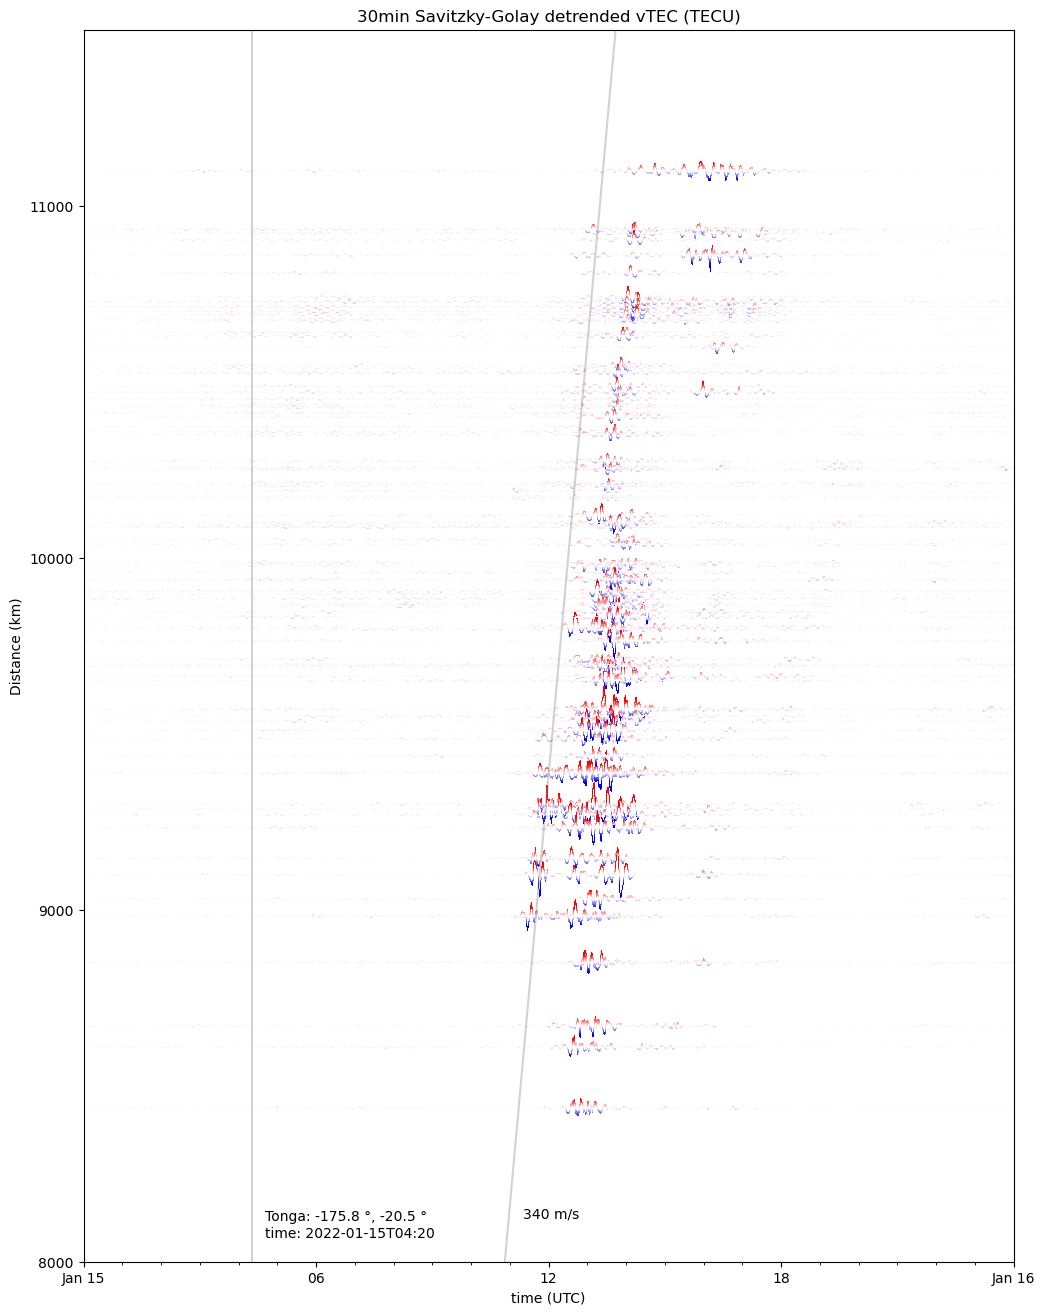

7894

In [16]:

# filtering = '1hr-2s'

fig = figure(figsize = (12, 16))
ax = fig.subplots()
cmap = plt.get_cmap('bwr')
clipcolors = cmap(np.linspace(0, 1, 128))
new_cmap = ListedColormap(clipcolors[66:])
    
plot_time_distance_vibration(ax, time, distances, data_norm*zoomer, vmin = vmin*zoomer, vmax = vmax*zoomer, cmap = 'bwr')
# plt.colorbar(im)

ax.axvline(epictime,
           color = 'grey',
           alpha = 0.35
          )
notes = f'Tonga: {epicenter_ll[0]} \N{DEGREE SIGN}, {epicenter_ll[1]} \N{DEGREE SIGN} \n' \
        f'time: {epictime}'
ax.annotate(notes, 
            [epictime, 8000 + (11500 - 8000)*0.02], 
            xytext=[10,0], 
            textcoords='offset points'
           )

pstart = 0
pend   = 12500
speed = 0.34
tstart = np.datetime64('2022-01-15T04:20','s')
tend   = epictime + np.timedelta64(int((pend - pstart)/speed), 's')
plot_arrival_time_line(ax, tstart, tend, pstart, pend, notes = '340 m/s', portion = 0.65)

# pstart = 12500
# pend   = 0
# speed = 0.31
# tend   = tstart + np.timedelta64(int(6374*2*np.pi/speed), 's')
# tstart = tend + np.timedelta64(int((pend - pstart)/speed), 's')
# plot_arrival_time_line(ax, tstart, tend, pstart, pend, notes = '310 m/s', portion = 0.25)

end   = dt.datetime(2022, 1, 16)

ticks = [0, 6, 12, 18]
ax.set_xlim(start, end)
ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
ax.xaxis.set_minor_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(format_func)


ax.set_ylim(8000, 11500)
ax.set_yticks(np.arange(8000, 12000, 1000))

ax.set_xlabel('time (UTC)')
ax.set_ylabel('Distance (km)')


ax.set_title(f'{filtering} vTEC (TECU)')
# ax.set_title(f'location: {epicenter_ll[0]} \N{DEGREE SIGN}, {epicenter_ll[1]} \N{DEGREE SIGN}', loc = 'right')
show()

savefile  = save_dir/f'detrended_vTEC_time_distance_{filtering}_vibration_Tonga.png'
fig.savefig(savefile, bbox_inches = 'tight', dpi = 1000)

fig.clf()
plt.clf()
plt.close('all')
plt.close(fig)
gc.collect()




In [17]:
# # filtering = '1hr-2s'

# fig = figure(figsize = (12, 16))
# ax = fig.subplots()
# cmap = plt.get_cmap('bwr')
# clipcolors = cmap(np.linspace(0, 1, 128))
# new_cmap = ListedColormap(clipcolors[66:])
    
# plot_time_distance_vibration(ax, time, distances, data_norm*zoomer, vmin = vmin*zoomer, vmax = vmax*zoomer, cmap = 'bwr')
# # plt.colorbar(im)

# # ax.axvline(epictime,
# #            color = 'grey',
# #            alpha = 0.35
# #           )
# # notes = f'Tonga: {epicenter_ll[0]} \N{DEGREE SIGN}, {epicenter_ll[1]} \N{DEGREE SIGN} \n' \
# #         f'time: {epictime}'
# # ax.annotate(notes, 
# #             [epictime, 8000 + (11500 - 8000)*0.02], 
# #             xytext=[10,0], 
# #             textcoords='offset points'
# #            )

# pstart = 0
# pend   = 12500
# speed = 0.34
# tstart = np.datetime64('2022-01-15T04:20','s')
# tend   = epictime + np.timedelta64(int((pend - pstart)/speed), 's')
# plot_arrival_time_line(ax, tstart, tend, pstart, pend, notes = '340 m/s', portion = 0.65)

# pstart = 12500
# pend   = 0
# speed = 0.31
# tend   = tstart + np.timedelta64(int(6374*2*np.pi/speed), 's')
# tstart = tend + np.timedelta64(int((pend - pstart)/speed), 's')
# plot_arrival_time_line(ax, tstart, tend, pstart, pend, notes = '310 m/s', portion = 0.35)

# start   = dt.datetime(2022, 1, 16)

# ticks = [0, 6, 12, 18]
# ax.set_xlim(start, end)
# ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
# ax.xaxis.set_minor_locator(mdates.HourLocator())
# ax.xaxis.set_major_formatter(format_func)


# ax.set_ylim(8000, 11500)
# ax.set_yticks(np.arange(8000, 12000, 1000))

# ax.set_xlabel('time (UTC)')
# ax.set_ylabel('Distance (km)')


# ax.set_title(f'{filtering} vTEC (TECU)')
# # ax.set_title(f'location: {epicenter_ll[0]} \N{DEGREE SIGN}, {epicenter_ll[1]} \N{DEGREE SIGN}', loc = 'right')
# show()

# savefile  = save_dir/f'detrended_vTEC_time_distance_{filtering}_vibration_Tonga.png'
# fig.savefig(savefile, bbox_inches = 'tight', dpi = 1000)

# fig.clf()
# plt.clf()
# plt.close('all')
# plt.close(fig)
# gc.collect()